In [29]:
# Import dependencies

import pandas as pd
import numpy as np
import time
import plotly.express as px
import plotly.graph_objects as go
import requests
import json
import matplotlib.pyplot as plt
import random as rd
import ipyvolume as ipv

from datetime import date
from datetime import datetime
from random import random
from geopy.geocoders import Nominatim
from shapely.geometry import shape, GeometryCollection, Point
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [30]:
# Read data from csv files
path_home_for_sale = "home_data/for_sale_data/home_for_sale_data_Feb-26-2021.csv"
path_home_sold = "home_data/sold_data/home_sold_data_Feb-26-2021.csv"

homes_for_sale = pd.read_csv(path_home_for_sale, index_col = 0)
homes_sold = pd.read_csv(path_home_sold, index_col = 0)

condition_1 = ~pd.isna(homes_for_sale['title'])
condition_2 = ~pd.isna(homes_sold['title'])

homes_for_sale= homes_for_sale[condition_1]
homes_sold = homes_sold[condition_2]

In [31]:
# # Refactor this section later
# homes_for_sale['list_price'] = str(homes_for_sale['list_price'])
# homes_sold['list_price'] = str(homes_sold['list_price'])

In [32]:
# print first 5 rows of homes for sale
homes_for_sale.head(5),homes_for_sale.shape


(                                 title MLS ID transaction_type  \
 4109  George Home | Apartment For Sale  ABC42         for sale   
 
                   home_type  level  first day on market  last day on market  \
 4109  Residential Apartment     19             20210226                 NaN   
 
       sold_price list_price  bedrooms  bathrooms  den     sqft exposure  \
 4109         NaN    500,000         1          1    1  500-600        E   
 
       parking  locker  maintanance fee  description  link  \
 4109      NaN     NaN              400  George Home   NaN   
 
                                             address  
 4109  1901 19 Bathurst St, Toronto, Ontario, M5V2P1  ,
 (1, 20))

In [33]:
# print first 5 rows of homes sold
homes_sold.head(5), homes_sold.shape

(                                        title    MLS ID transaction_type  \
 0        46 White Oak Blvd | House Sold Price  W5094751             sold   
 1          264 Gilbert Ave | House Sold Price  W5095155             sold   
 2   2596 Lake Shore Blvd W | House Sold Price  W5092458             sold   
 3          88 Southwood Dr | House Sold Price  E5101930             sold   
 4  15 North Bonnington Ave | House Sold Price  E5086758             sold   
 
            home_type level  first day on market  last day on market  \
 0  Residential House   NaN           20210125.0          20210201.0   
 1  Residential House   NaN           20210126.0          20210202.0   
 2  Residential House   NaN           20210121.0          20210122.0   
 3  Residential House   NaN           20210202.0          20210202.0   
 4  Residential House   NaN           20210117.0          20210203.0   
 
   sold_price list_price  bedrooms  bathrooms  den       sqft exposure parking  \
 0  2,125,727  1,799

In [34]:
# only see condos
condition_lst_1 = (homes_for_sale['home_type'] == 'Residential Apartment') | (homes_for_sale['home_type'] == 'Residential Condo Apt')
condition_lst_2 = homes_sold['home_type'] == 'Residential Apartment'

condos_for_sale = homes_for_sale[condition_lst_1]
condos_sold = homes_sold[condition_lst_2]

In [35]:
# check condos for sale
condos_for_sale.shape, condos_for_sale.head(5)

((1, 20),
                                  title MLS ID transaction_type  \
 4109  George Home | Apartment For Sale  ABC42         for sale   
 
                   home_type  level  first day on market  last day on market  \
 4109  Residential Apartment     19             20210226                 NaN   
 
       sold_price list_price  bedrooms  bathrooms  den     sqft exposure  \
 4109         NaN    500,000         1          1    1  500-600        E   
 
       parking  locker  maintanance fee  description  link  \
 4109      NaN     NaN              400  George Home   NaN   
 
                                             address  
 4109  1901 19 Bathurst St, Toronto, Ontario, M5V2P1  )

In [36]:
# check condos sold
condos_sold.shape, condos_sold.head(5)

((2589, 20),
                                                title    MLS ID  \
 7          3 Rowntree Rd 2407 | Apartment Sold Price  W5096809   
 8   88 Palace Pier Crt Ph 104 | Apartment Sold Price  W5091884   
 9     1070 Sheppard Ave W 415 | Apartment Sold Price  W5090502   
 10        16 Brookers Ln 1601 | Apartment Sold Price  W5086444   
 11       40 Panorama Crt 1109 | Apartment Sold Price  W5077256   
 
    transaction_type              home_type level  first day on market  \
 7              sold  Residential Apartment    23           20210128.0   
 8              sold  Residential Apartment    12           20210122.0   
 9              sold  Residential Apartment     4           20210120.0   
 10             sold  Residential Apartment    16           20210116.0   
 11             sold  Residential Apartment    11           20210106.0   
 
     last day on market sold_price list_price  bedrooms  bathrooms  den  \
 7           20210202.0    536,000    529,900       2.0       

In [37]:
# Plot nornmalized historgram for sold price
raw_sold_price = list(condos_sold['sold_price'])
raw_sold_price_lst = []

for p in raw_sold_price:
    price_lst = p.split(',')
    sold_price = int(''.join(price_lst))
    raw_sold_price_lst.append(sold_price)
    
# remove outliers to plot
sold_price_lst = np.array(raw_sold_price_lst)

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

sold_price_lst = reject_outliers(sold_price_lst)

fig = go.Figure(data=[go.Histogram(x=sold_price_lst, histnorm='probability')])
fig.show()

# test if sold prices is normal

k2, p = stats.normaltest(raw_sold_price_lst)
alpha = 1e-3
if p < alpha:  # null hypothesis: sold_price_lst comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
# So that sold_price_lst is not Normal

stats.percentileofscore(raw_sold_price_lst, 1200000)
np.std(raw_sold_price_lst),np.std(sold_price_lst)


The null hypothesis can be rejected


(317846.1555290453, 168357.03459227472)

In [38]:
# Find the trend of number of sold homes through time (daily)

last_day_on_markets_lst = list(condos_sold['last day on market'])
min_day = min(last_day_on_markets_lst)
max_day = max(last_day_on_markets_lst)

min_day, max_day


(20181128.0, 20210226.0)

In [39]:
# cleaning condos_for_sale, remove rows without listing_price
have_listing_price = [False if "detail-price" in str(p) else True for p in condos_for_sale['list_price']]

have_sqft = ~pd.isna(condos_for_sale['sqft'])

condos_for_sale_copy = condos_for_sale[have_listing_price & have_sqft]

condos_merge_df = pd.concat([condos_for_sale_copy, condos_sold], ignore_index=True, sort=False)


# Find the trend of number of new listing homes through time (daily)
# Unlike the sold day, first day appears both in for sale listing and sold listing
first_day_on_markets_lst = list(condos_for_sale['first day on market']) + list(condos_sold['first day on market'])

min_first_day = min(first_day_on_markets_lst)
max_first_day = max(first_day_on_markets_lst)

min_first_day, max_first_day

(20180818.0, 20210226)

In [40]:
def plot_price_time_series(data_frame, cutoff_day, n_moving_average, config):
    
    price_per_sqft_dict = {} #key: int-day, value: [sqft, price]
    v = config['day']
    p = config['price']
    
    for index, row in data_frame.iterrows():
        date = int(row[v])
        if date >= cutoff_day:
            price = row[p]
            price_lst = price.split(',')
            price = int(''.join(price_lst))


            sqft = row['sqft']
            
            if not isinstance(sqft, float):
                sqft_lst = sqft.split('-')
                first_part = sqft_lst[0]
                
                # corner case: 5000+
                if "+" in first_part:
                    idx = first_part.index("+")
                    first_part = first_part[:idx]
                    sqft_lst = [first_part]
                
                if int(first_part) == 0:
                    sqft = int(sqft_lst[1])
                else:
                    sqft_lst = [int(a) for a in sqft_lst]
                    sqft = sum(sqft_lst) / len(sqft_lst)

            if date not in price_per_sqft_dict:
                price_per_sqft_dict[date] = [sqft, price]
            else:
                price_per_sqft_dict[date][0] += sqft
                price_per_sqft_dict[date][1] += price

    x_lst = list(price_per_sqft_dict.keys())
    x_lst.sort()
    
    y_lst = [price_per_sqft_dict[x][1]/price_per_sqft_dict[x][0] for x in x_lst]
    
    # transfer y_lst to moving average, naive way to do the average
    half_boundary = (n_moving_average - 1) // 2

    left = half_boundary
    right = len(y_lst) - half_boundary

    y_average = []

    for i in range(len(y_lst)):

        if i >= half_boundary and i < right:
            value = sum(y_lst[i - half_boundary : i + half_boundary + 1]) / n_moving_average
            y_average.append(value)



    x_lst = x_lst[half_boundary:right]
    x_lst = [str(x) for x in x_lst]
   
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_lst, y=y_average,
                        mode='lines+markers',
                        name='line + number',
                        marker_color='rgba(255, 102, 102, 1)'))
    fig.show()

In [41]:
# Find the trend of sold price per sqft
sold_config = {}
sold_config['day'] = 'last day on market'
sold_config['price'] = 'sold_price'
plot_price_time_series(condos_sold, cutoff_day=20201201, n_moving_average=10, config=sold_config)

In [42]:
# Find the trend of listing price per sqft
list_config = {}
list_config['day'] = 'first day on market'
list_config['price'] = 'list_price'

# condos_for_sale_copy
# condos_merge_df

plot_price_time_series(condos_merge_df, cutoff_day=20201213, n_moving_average=10, config=list_config)

In [43]:
# Given a cutoff day, plot new listing number or sold number through time (daily) 
# if n_days_average is specified, plot moving number plot
def plot_single_day_data(date_lst, cutoff_day, n_days_average=0):
    num_per_day_dict = {}

    for d in date_lst:
        d_string = str(int(d))

        if d_string not in num_per_day_dict:
            num_per_day_dict[d_string] = 1
        else:
            num_per_day_dict[d_string] += 1

    days = list(num_per_day_dict.keys())

    days = [int(d) for d in days]
    days.sort()

    num_lst = [num_per_day_dict[str(d)] for d in days if d >= cutoff_day]

    x_axis = [str(d) for d in days if d >= cutoff_day]
    
    
    if n_days_average == 0:

        fig = go.Figure()

#         fig.add_trace(go.Scatter(x=x_axis, y=num_lst,
#                             mode='markers',
#                             name='number'))
        fig.add_trace(go.Scatter(x=x_axis, y=num_lst,
                            mode='lines+markers',
                            name='line + number',
                            marker_color='rgba(255, 102, 102, 1)'
                                ))

        fig.show()
    else:
        half_boundary = (n_days_average - 1) // 2

        left = half_boundary
        right = len(num_lst) - half_boundary

        homes_num_average = []

        for i in range(len(num_lst)):

            if i >= half_boundary and i < right:
                value = sum(num_lst[i - half_boundary : i + half_boundary + 1]) / n_days_average
                homes_num_average.append(value)



        x_average = x_axis[half_boundary:right]

        assert(len(x_average) == len(homes_num_average))

        fig = go.Figure()

#         fig.add_trace(go.Scatter(x=x_average, y=homes_num_average,
#                             mode='markers',
#                             name='number sold'))
        fig.add_trace(go.Scatter(x=x_average, y=homes_num_average,
                            mode='lines+markers',
                            name='line + number',
                            marker_color='rgba(255, 102, 102, 1)'))

        fig.show()

In [44]:
# Plot home sold number per day
plot_single_day_data(last_day_on_markets_lst, cutoff_day=20201215)

In [45]:
# Plot average home sold number per day
plot_single_day_data(last_day_on_markets_lst, cutoff_day=20201215, n_days_average=7)

In [46]:
# Plot new home listing number per day
plot_single_day_data(first_day_on_markets_lst, cutoff_day=20201215)

In [47]:
# plot average new home listing number per day
plot_single_day_data(first_day_on_markets_lst, cutoff_day=20201215, n_days_average=7)

In [48]:
# Plot stacked bar chart for sold number per week
import datetime as dt

last_day_on_markets_lst = list(condos_sold['last day on market'])
max_day = int(max(last_day_on_markets_lst))

max_day = datetime.strptime(str(max_day), '%Y%m%d')
# print(max_day)

# need to change 2020-11-21 to expected starting date
begin_day = datetime.strptime('2021-01-04', '%Y-%m-%d')
Monday_lst = []

while begin_day < max_day:
    if begin_day < max_day:
        Monday_lst.append(begin_day)

    nxt_monday = begin_day + dt.timedelta(days=7) #move to next Monday
    begin_day = nxt_monday
    
# print(Monday_lst)
# for d in Monday_lst:
#     print(d)

y_buy_side = {}
y_sell_side = {}

for d in Monday_lst:
    s = d.strftime("%Y-%m-%d")
    y_buy_side[s] = 0
    y_sell_side[s] = 0

for index, row in condos_sold.iterrows():
    sold_price = row['sold_price']
    sold_price_lst = sold_price.split(',')
    sold_price = int(''.join(sold_price_lst))
    
    list_price = row['list_price']
    list_price_lst = list_price.split(',')
    
    list_price = int(''.join(list_price_lst))

    
    sold_day = int(row['last day on market'])
    sold_day = datetime.strptime(str(sold_day), '%Y%m%d')
    
    
    # locate the "Monday" for this sold day
    for monday in Monday_lst:
        sunday = monday + dt.timedelta(days=6)
        if monday <= sold_day and sold_day <= sunday:
            m_d = monday.strftime("%Y-%m-%d")
            if sold_price < list_price:
                y_buy_side[m_d] += 1
            else:
                y_sell_side[m_d] += 1
            
            break


Monday_lst = [m.strftime("%Y-%m-%d") for m in Monday_lst]

y_sell = [y_sell_side[x] for x in Monday_lst]
y_buy = [y_buy_side[x] for x in Monday_lst]

# Plot job
fig = go.Figure()
fig.add_trace(go.Bar(x=Monday_lst,
                y=y_buy,
                name='buyer market transaction',
                marker_color='rgb(190, 66, 66)'
                ))
fig.add_trace(go.Bar(x=Monday_lst,
                y=y_sell,
                name='seller market transaction',
                marker_color='rgb(26, 118, 255)'
                ))

fig.update_layout(
    title='buyer market vs seller market (weekly)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='CAD',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()


In [49]:
# Find the trend of the Ratio(Daily): number of new listing / number of sold

In [50]:
def helper_for_ratio(date_lst):
    num_per_day_dict = {}

    for d in date_lst:
        d_string = str(int(d))

        if d_string not in num_per_day_dict:
            num_per_day_dict[d_string] = 1
        else:
            num_per_day_dict[d_string] += 1
    return num_per_day_dict

def helper_plot(x_lst, y_lst):
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=x_lst, y=y_lst,
                        mode='lines+markers',
                        name='line + number',
                        marker_color='rgba(255, 102, 102, 1)'))

    fig.show()
    
"""date_lst is the semi-target dates""" 
def helper_calculate_average_num(num_dict, date_lst , n_days_average):
    
    half_boundary = (n_days_average - 1) // 2

    left = half_boundary
    right = len(date_lst) - half_boundary
     
    num_lst = [num_dict[str(d)] for d in date_lst]
    target_dict = {}
        
    for i in range(len(date_lst)):

        if i >= half_boundary and i < right:
            value = sum(num_lst[i - half_boundary : i + half_boundary + 1]) / n_days_average
            target_dict[str(date_lst[i])] = value

    return target_dict
    

# if n_days_average is not 0, plot the average n days ratio
def plot_the_sell_buy_ratio(new_listing_dates, sold_dates, cutoff_day, n_days_average=0):
    # for new listing, get the dictionary {listing date : num of listing}
    new_listing_dict = helper_for_ratio(new_listing_dates)
    
    # for sold homes, get the dictionary {sold date : num of sold homes}
    sold_dict = helper_for_ratio(sold_dates)

    
    listing_days = list(new_listing_dict.keys())
    listing_days = [int(d) for d in listing_days if int(d) >= cutoff_day]
    listing_days.sort()
    
    sold_days = list(sold_dict.keys())
    sold_days = [int(d) for d in sold_days if int(d) >= cutoff_day]
    sold_days.sort()
    
    
    
    if n_days_average == 0:
        # get the intersection
        ratio_dates = list(set(listing_days).intersection(set(sold_days)))
        ratio_dates.sort()
        
        ratio_lst = [new_listing_dict[str(ratio_dates[i])] / sold_dict[str(ratio_dates[i])] for i in range(len(ratio_dates))]
        x_axis = [str(d) for d in ratio_dates]
        helper_plot(x_lst=x_axis, y_lst=ratio_lst)
        
    else:
        # for listing dates, create list of average number based on current listing days(after cutoff)
        # Return dictionary {date : mean num}
        mean_listing_dict = helper_calculate_average_num(new_listing_dict, listing_days, n_days_average)
        
        # for sold dates, create list of average number based on current sold days(after cutoff)
        # Return dictionary {date : mean num}
        mean_sold_dict = helper_calculate_average_num(sold_dict, sold_days, n_days_average)
        
        # get the intersection
        ratio_dates = list(set(mean_listing_dict.keys()).intersection(set(mean_sold_dict.keys())))
        ratio_dates.sort()
        
        ratio_lst = [mean_listing_dict[str(ratio_dates[i])] / mean_sold_dict[str(ratio_dates[i])] for i in range(len(ratio_dates))]
        x_axis = [str(d) for d in ratio_dates]
        helper_plot(x_lst=x_axis, y_lst=ratio_lst)

In [51]:
# Plot the trend of the Ratio(Daily): number of new listing / number of sold 
plot_the_sell_buy_ratio(new_listing_dates=first_day_on_markets_lst, 
                        sold_dates=last_day_on_markets_lst, 
                        cutoff_day=20201215)

In [52]:
# Plot the trend of the Ratio(Daily, average): number of new listing / number of sold 
plot_the_sell_buy_ratio(new_listing_dates=first_day_on_markets_lst, 
                        sold_dates=last_day_on_markets_lst, 
                        cutoff_day=20201215,n_days_average=7)

In [53]:
# plot Inventory number through time(daily)
def plot_inventory_per_day(for_sale_lst, sold_first_day_lst, sold_last_day_lst, cutoff_day=0, n_days_average=0):
    sold_dict = helper_for_ratio(sold_last_day_lst)
    sold_days = list(sold_dict.keys())
    sold_days = [int(d) for d in sold_days if int(d) >= cutoff_day]
    sold_days.sort()
    
    inventory_dict = {}
    # populate inventory_dict based on sold_days
    for sold_day in sold_days:
        for i in range(len(sold_first_day_lst)):
            first_day = int(sold_first_day_lst[i])
            last_day =  int(sold_last_day_lst[i])
            if first_day <= sold_day < last_day:
                if str(sold_day) not in inventory_dict:
                    inventory_dict[str(sold_day)] = 1
                else:
                    inventory_dict[str(sold_day)] += 1
            
    
    # update inventory through active sale list
    for sold_day in sold_days:
        for i in range(len(for_sale_lst)):
            first_day = int(for_sale_lst[i])
            
            if first_day <= sold_day:
                if str(sold_day) not in inventory_dict:
                    inventory_dict[str(sold_day)] = 1
                else:
                    inventory_dict[str(sold_day)] += 1
                    
    
    #create date array for plot single day function
    lst = []
    for k,v in inventory_dict.items():
        for i in range(v):
            lst.append(k)

    plot_single_day_data(lst, cutoff_day=0, n_days_average=n_days_average)


In [54]:
# Plot Inventory number through time
for_sale_lst = list(condos_for_sale['first day on market'])
sold_first_day_lst = list(condos_sold['first day on market'])
sold_last_day_lst = list(condos_sold['last day on market'])

plot_inventory_per_day(for_sale_lst, sold_first_day_lst, sold_last_day_lst, cutoff_day=20201215)

In [55]:
# Plot average Inventory number through time
for_sale_lst = list(condos_for_sale['first day on market'])
sold_first_day_lst = list(condos_sold['first day on market'])
sold_last_day_lst = list(condos_sold['last day on market'])

plot_inventory_per_day(for_sale_lst, sold_first_day_lst, sold_last_day_lst, cutoff_day=20201215,n_days_average=7)

In [56]:
# Find the trend of the Ratio(Daily): number of On Sale(Total Inventory) / number of sold 
def plot_inventory_sold_ratio(for_sale_lst, sold_first_day_lst, sold_last_day_lst, cutoff_day=0, n_days_average=0):
    sold_dict = helper_for_ratio(sold_last_day_lst)
    sold_days = list(sold_dict.keys())
    sold_days = [int(d) for d in sold_days if int(d) >= cutoff_day]
    sold_days.sort()
    
    inventory_dict = {}
    # populate inventory_dict based on sold_days
    for sold_day in sold_days:
        for i in range(len(sold_first_day_lst)):
            first_day = int(sold_first_day_lst[i])
            last_day =  int(sold_last_day_lst[i])
            if first_day <= sold_day < last_day:
                if str(sold_day) not in inventory_dict:
                    inventory_dict[str(sold_day)] = 1
                else:
                    inventory_dict[str(sold_day)] += 1
            
    
    # update inventory through active sale list
    for sold_day in sold_days:
        for i in range(len(for_sale_lst)):
            first_day = int(for_sale_lst[i])
            
            if first_day <= sold_day:
                if str(sold_day) not in inventory_dict:
                    inventory_dict[str(sold_day)] = 1
                else:
                    inventory_dict[str(sold_day)] += 1
                    
    if n_days_average == 0:
        inventory_keys = [int(k) for k in list(inventory_dict.keys())]

        ratio_dates = list(set(sold_days).intersection(set(inventory_keys)))
        ratio_dates.sort()
        
        ratio_lst = [inventory_dict[str(ratio_dates[i])] / sold_dict[str(ratio_dates[i])] for i in range(len(ratio_dates))]
        x_axis = [str(d) for d in sold_days]
        helper_plot(x_lst=x_axis, y_lst=ratio_lst)
        
    else:
        inventory_keys = [int(k) for k in list(inventory_dict.keys())]
        mean_inventory_dict = helper_calculate_average_num(inventory_dict, inventory_keys, n_days_average)
        
        mean_sold_dict = helper_calculate_average_num(sold_dict, sold_days, n_days_average)
        
        # get the intersection
        ratio_dates = list(set(mean_inventory_dict.keys()).intersection(set(mean_sold_dict.keys())))
        ratio_dates.sort()
        
        ratio_lst = [mean_inventory_dict[str(ratio_dates[i])] / mean_sold_dict[str(ratio_dates[i])] for i in range(len(ratio_dates))]
        x_axis = [str(d) for d in ratio_dates]
        helper_plot(x_lst=x_axis, y_lst=ratio_lst)

In [57]:
# Plot inventory-vs-sold ratio through time(daily)
for_sale_lst = list(condos_for_sale['first day on market'])
sold_first_day_lst = list(condos_sold['first day on market'])
sold_last_day_lst = list(condos_sold['last day on market'])

plot_inventory_sold_ratio(for_sale_lst, sold_first_day_lst, sold_last_day_lst, cutoff_day=20201215)

In [58]:
# Plot average-inventory-vs-sold ratio through time(daily)
for_sale_lst = list(condos_for_sale['first day on market'])
sold_first_day_lst = list(condos_sold['first day on market'])
sold_last_day_lst = list(condos_sold['last day on market'])

plot_inventory_sold_ratio(for_sale_lst, sold_first_day_lst, sold_last_day_lst, cutoff_day=20201201, n_days_average=10)

In [30]:
start_time = time.time()

In [59]:
# reinitilize condos_sold and condos_for_sale
condition_lst_1 = (homes_for_sale['home_type'] == 'Residential Apartment') | (homes_for_sale['home_type'] == 'Residential Condo Apt')
condition_lst_2 = homes_sold['home_type'] == 'Residential Apartment'
condition_3 = homes_sold['last day on market'] > 20210115
 
condos_for_sale = homes_for_sale[condition_lst_1]
condos_sold = homes_sold[condition_lst_2 & condition_3]

condos_sold_num_row = condos_sold.shape[0]
temp_array = pd.Series(list(range(0, condos_sold_num_row)))
condos_sold = condos_sold.set_index(temp_array)
condos_sold.head(5)
condos_sold.shape[0]


2521

In [60]:
# Set up for Choropleth Map
with open('Toronto.geojson') as json_file:
    toronto_areas = json.load(json_file)

id_lst = []
for feature in toronto_areas['features']:
    id = feature['properties']['_id']
    id_lst.append(id)

# create id_sqft_dict and id_price_lst
id_sqft_dict, id_price_dict = {},{}

for id in id_lst:
    id_sqft_dict[str(id)] = 0
    id_price_dict[str(id)] = 0
    
error_counter = 0
counter = 1

# initilize 3 list for later use (KNN)
later_use_average_price, later_use_longitude, later_use_latitude = [], [], []

for index, row in condos_sold.iterrows():
    assert(row['home_type'] == 'Residential Apartment')
    
    sold_price = row['sold_price']
    price_lst = sold_price.split(',')
    sold_price = int(''.join(price_lst))
    
    # corner case: 5000+
    sqft = row['sqft']
    sqft_lst = sqft.split('-')
    
    first_part = sqft_lst[0]
    
    if "+" in first_part:
        idx = first_part.index("+")
        sqft = int(first_part[:idx])
        later_use_average_price.append(sold_price / sqft)
    
    elif int(first_part) == 0:
        sqft = int(sqft_lst[1])
        later_use_average_price.append(sold_price / sqft)
    else:
        sqft_lst = [int(a) for a in sqft_lst]
        sqft = sum(sqft_lst) / len(sqft_lst)
        later_use_average_price.append(sold_price/sqft)
    
    raw_address = row['address']
    raw_address_parts = raw_address.split(',')
    address = raw_address_parts[0]
    address_parts = address.split(' ')
    final_address = ' '.join(address_parts[1:]) + ', Toronto'
    
    try:
        geolocator = Nominatim(user_agent="toronto_goose")
        location = geolocator.geocode(final_address)
        
        point = Point(location.longitude, location.latitude)
        later_use_longitude.append(location.longitude)
        later_use_latitude.append(location.latitude)
        
        # if gelocator does not find the address, won't get this line
        counter+=1
        if_found = False
        for feature in toronto_areas['features']:

            polygon = shape(feature['geometry'])

            if polygon.contains(point):
                id = feature['properties']['_id']
                
                id_sqft_dict[str(id)] += sqft
                id_price_dict[str(id)] += sold_price
                if_found = True
                break
        if not if_found:
            print("Error: In toronto neighbourhooods, can not find address: {}".format(raw_address))
    except:
        error_counter += 1
        later_use_longitude.append(np.nan)
        later_use_latitude.append(np.nan)
        #print("error: {}".format(raw_address))
        
    if counter % 100 == 0:
        print("complete {} hundred homes".format(counter))
        
# create unemp array
unemp = []
for id in id_lst:
    price_toal = id_price_dict[str(id)]
    sqft_total = id_sqft_dict[str(id)]
    if price_toal != 0 and sqft_total !=0:
        average_price = price_toal / sqft_total
        unemp.append(average_price)
    else:
        unemp.append(0)
        print('There is no data for area id: {}'.format(id))

assert(len(unemp) == len(id_lst))
print("Miss {} out of {} address in total".format(error_counter, condos_sold.shape[0]))

complete 100 hundred homes
complete 200 hundred homes
complete 300 hundred homes
complete 400 hundred homes
complete 500 hundred homes
Error: In toronto neighbourhooods, can not find address: 615 460 Adelaide St, Toronto, Ontario, M5A1N6
complete 600 hundred homes
complete 700 hundred homes
Error: In toronto neighbourhooods, can not find address: 3209 290 Adelaide St, Toronto, Ontario, M5V1P7
complete 800 hundred homes
complete 900 hundred homes
complete 1000 hundred homes
complete 1100 hundred homes
complete 1200 hundred homes
complete 1300 hundred homes
complete 1400 hundred homes
complete 1500 hundred homes
complete 1600 hundred homes
complete 1700 hundred homes
complete 1800 hundred homes
complete 1900 hundred homes
complete 2000 hundred homes
complete 2100 hundred homes
complete 2200 hundred homes
complete 2300 hundred homes
complete 2400 hundred homes
Error: In toronto neighbourhooods, can not find address: 1806 295 Adelaide St, Toronto, Ontario, M5V1P7
There is no data for area 

In [33]:
# Plot the Toronto price Choropleth Map 
fig = go.Figure(go.Choroplethmapbox(geojson=toronto_areas, locations=id_lst, z=unemp,
                                    colorscale="Oryel", zmin=300, zmax=1500,
                                    marker_opacity=0.5, marker_line_width=0))
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=9.5, mapbox_center = {"lat": 43.651070, "lon": -79.347015})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_traces(featureidkey='properties._id', selector=dict(type='choroplethmapbox'))
fig.show()

print('When Plot map, time: %.2f' % (time.time() - start_time))

When Plot map, time: 1261.48


In [61]:
len(later_use_average_price), len(later_use_latitude), len(later_use_longitude), condos_sold.shape

(2521, 2521, 2521, (2521, 20))

60.120240480961925
2562.184727778744
total: 5 price level


4

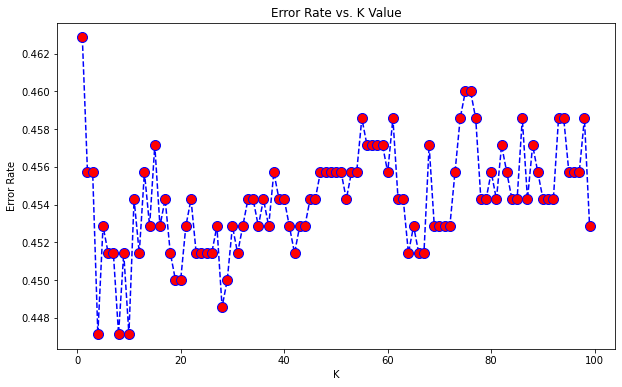

In [62]:
# Use KNN to "see" the price map again(price/sqft classification)
print(min(later_use_average_price))
print(max(later_use_average_price))

# Set up
condos_sold = homes_sold[condition_lst_2 & condition_3]
condos_sold_num_row = condos_sold.shape[0]
temp_array = pd.Series(list(range(0, condos_sold_num_row)))
condos_sold = condos_sold.set_index(temp_array)

condos_sold['price per sqft'] = later_use_average_price
condos_sold['latitude'] = later_use_latitude
condos_sold['longitude'] = later_use_longitude

# remove outlier rows in term of price per sqft
mu = np.mean(later_use_average_price)
sd = np.std(later_use_average_price)
num_sd = 2

bool_lst = [abs(p-mu) < num_sd*sd for p in later_use_average_price]
condos_sold = condos_sold[bool_lst]


# remove Nan for coordinates
condos_sold.dropna(subset=['latitude', 'longitude'], inplace=True)




condos_sold_num_row = condos_sold.shape[0]
temp_array = pd.Series(list(range(0, condos_sold_num_row)))
condos_sold = condos_sold.set_index(temp_array)

# condos_sold.tail(5)
price_slice = 200

price_level = []


for p in condos_sold['price per sqft']:
    p_id = int(p // price_slice)
    price_level.append(p_id)

# keep price_level_id unchanged, make a mapping from price_level to price_level_id
price_level_mapping = {}
price_level_copy = [i for i in price_level]

# for copy, remain unique
price_leve_copy = list(set(price_level_copy))
print("total: {} price level".format(len(price_leve_copy)))
price_leve_copy.sort()

for level in price_level_copy:
    level_id = price_leve_copy.index(level)
    price_level_mapping[str(level)] = level_id



price_level_id = [price_level_mapping[str(level)] for level in price_level]

condos_sold['price_level_id'] = price_level_id

# condos_sold.head(10)

# determine K value
df_train, df_test = train_test_split(condos_sold, test_size=0.3)

X_train = df_train[['latitude', 'longitude']]
y_train = df_train.price_level_id

X_test = df_test[['latitude', 'longitude']]
y_test = df_test.price_level_id

error_rate = []

record = 1
k = 0
num_k = 100
amazing_knn = None

# Will take some time
for i in range(1,num_k): 
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn = knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

    if np.mean(pred_i != y_test) < record:
        k = i
        amazing_knn = knn
        record = np.mean(pred_i != y_test)





plt.figure(figsize=(10,6))
plt.plot(range(1, num_k), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')


k

# Choose k value








In [63]:
# Explore the Kmean approach to determine price_level_id for homes for sale
# from sklearn.preprocessing import MinMaxScaler
# # Set up
# df_sold = homes_sold[condition_lst_2 & condition_3]
# df_sold_num_row = df_sold.shape[0]
# temp_array = pd.Series(list(range(0, df_sold_num_row)))
# df_sold = df_sold.set_index(temp_array)

# df_sold['price per sqft'] = later_use_average_price
# df_sold['latitude'] = later_use_latitude
# df_sold['longitude'] = later_use_longitude
# # print(df_sold.shape)
# # remove Nan for coordinates
# df_sold.dropna(subset=['latitude', 'longitude'], inplace=True)

# #remove outlier in coordinates
# num_sd = 2

# longitude_mu = np.mean(df_sold['longitude'])
# longitude_sd = np.std(df_sold['longitude'])
# bool_lst_1 = np.array([abs(long-longitude_mu) < num_sd * longitude_sd for long in df_sold['longitude']])

# latitude_mu = np.mean(df_sold['latitude'])
# latitude_sd = np.std(df_sold['latitude'])
# bool_lst_2 = np.array([abs(lat-latitude_mu) < num_sd * latitude_sd for lat in df_sold['latitude']])

# df_sold = df_sold[(bool_lst_1) & (bool_lst_2)]

# # Create X 
# # scaler = StandardScaler()
# # scaler = MinMaxScaler()
# # # data = [df_sold['latitude'], df_sold['longitude'], df_sold['price per sqft']]
# # data = [df_sold['latitude'], df_sold['longitude']]
# # scaler.fit(data)
# # X_kmean = scaler.transform(data)
# # X_kmean = X_kmean.T



# X_kmean = []
# x_axis, y_axis, z_axis = [], [], []
# for index, row in df_sold.iterrows():
#     h = lambda x: x
#     f = lambda x: x**2 if x > 0 else -x**2
#     g = lambda x: x**3
#     k = lambda x: np.e ** x
#     q = lambda x: np.log(x)
    
#     x = k(row["latitude"])
#     y = k(row["longitude"])
#     z = h(row["price per sqft"])
    
#     x_axis.append(x)
#     y_axis.append(y)
#     z_axis.append(z)
    
#     point = [x, y, z]
#     X_kmean.append(point)
    
# X_kmean =np.array(X_kmean)

In [64]:
# x_axis, y_axis = [X[0] for X in X_kmean],[X[1] for X in X_kmean]

In [65]:
# fig = pyplot.figure()
# ax = Axes3D(fig)

# # ax.scatter(xs=x_axis, ys=y_axis, zs=z_axis)
# ax.scatter(xs=x_axis, ys=y_axis,zs=z_axis)
# pyplot.show()

In [66]:
# # find the optimal K
# wcss = []
# for i in range(1, 21):
#     kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#     kmeans.fit(X_kmean)
#     wcss.append(kmeans.inertia_)
#     print("{} / 20 completed".format(i))
    
# plt.plot(range(1, 21), wcss)
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

In [67]:
# # So, choose K = 3 based on Elbow plot
# n_clusters = 3
# amazing_kmeans = KMeans(n_clusters=n_clusters)
# amazing_kmeans = amazing_kmeans.fit(X_kmean)
# labels = amazing_kmeans.predict(X_kmean)


In [68]:
# # plot 3D with lables
# fig = pyplot.figure()
# ax = Axes3D(fig)

# # ax.scatter(x_axis, y_axis, z_axis, c=labels)
# ax.scatter(X_kmean[0], X_kmean[1], X_kmean[2], c=labels)
# pyplot.show()

In [69]:
# kmean conclusion: Do not find a good geo pattern. Thus, don't consider Kmean

In [70]:
# Explore the pricing model

# Decision tree approach: good fit

# condos_sold.columns
def get_X_and_y(df):
    X = df.drop(columns=['title', 'MLS ID', 'transaction_type', 'home_type',
                        'first day on market', 'last day on market', 
                         'sold_price', 'list_price', 'description', 
                         'link', 'address', 'price per sqft', 
                         'latitude', 'longitude'])


    # column_variables = list(X.columns)
    # for v in column_variables:
    #     t = type(X[v][0])
    #     print("{}: {}".format(v, t))

    # data massage job 
    new_level = []
    # below levels are hard code hard code

    lower_levels = [str(i) for i in range(11)] + ['A', 'B'] 
    middle_levels = [str(i) for i in range(11,21)]
    
    for l in X['level']:
        if l in lower_levels:
            new_level.append(0)
        elif l in middle_levels:
            new_level.append(1)
        else:
            new_level.append(2)

    new_sqft = []
    for s in X['sqft']:
        sqft_lst = s.split('-')
        
        first_part = sqft_lst[0]
         # corner case: 5000+
        if "+" in first_part:
            idx = first_part.index("+")
            first_part = first_part[:idx]
            sqft_lst = [first_part]
        
        if int(first_part) == 0:
            new_sqft.append(int(sqft_lst[1]))
        else:
            sqft_lst = [int(a) for a in sqft_lst]
            sqft = sum(sqft_lst) / len(sqft_lst)
            new_sqft.append(sqft)


    new_exposure = []
    for s in X['exposure']:
        temp = s.lower()
        if "e" in temp:
            new_exposure.append(0)
        elif "s" in temp:
            new_exposure.append(1)
        elif "w" in temp:
            new_exposure.append(2)
        elif "n" in temp:
            new_exposure.append(3)
        else:
            print('error')

    new_parking = []
    for p in X['parking']:
        p = p.lower()
        if 'none' in p:
            new_parking.append(0)
        else:
            new_parking.append(1)

    new_locker = []
    for l in X['locker']:
        l = l.lower()
        if 'none' in l:
            new_locker.append(0)
        else:
            new_locker.append(1)

    # deal with Nan
    values = {'maintanance fee': 0}
    X.fillna(value=values, inplace=True)

    new_maintain_fee = []
    fee_low_threshod = 500
    fee_high_threshod = 1000
    for fee in X['maintanance fee']:
        fee = int(fee)
        if fee < fee_low_threshod:
            new_maintain_fee.append(0)
        elif fee < fee_high_threshod:
            new_maintain_fee.append(1)
        else:
            new_maintain_fee.append(2)


    X['level'] = new_level
    X['sqft'] = new_sqft
    X['exposure'] = new_exposure
    X['parking'] = new_parking
    X['locker'] = new_locker
    X['maintanance fee'] = new_maintain_fee

    X = pd.get_dummies(X, columns=['level', 'parking', 'locker', 'price_level_id',
                                   'exposure', 'maintanance fee'], prefix_sep='=') 



    y = []

    for p in df['sold_price']:
        price_lst = p.split(',')
        sold_price = int(''.join(price_lst))
        y.append(sold_price)

    y = pd.Series(y)
    return X, y

def plant_tree(regressor, train_X, train_y, test_X, test_y):
        regressor.fit(train_X, train_y)
        
        # R^2 score
        print("R^2 score: {}".format(regressor.score(train_X, train_y)))
        
        # cross validation
        print("Cross validation Scores: {}".format(cross_val_score(regressor, train_X, train_y, cv=5)))
        
        # predict
        y_pred = regressor.predict(test_X)
        print("Mean Absolute Error: {}".format(mean_absolute_error(test_y, y_pred)))
        
        min_num = min(test_y.min(), y_pred.min())
        max_num = max(test_y.max(), y_pred.max())
        
        fig = px.scatter(x=test_y, y=y_pred, labels={'x': 'ground truth', 'y': 'prediction'})
        fig.add_shape(
            type="line", line=dict(dash='dash'),
            x0=min_num, y0=min_num,
            x1=max_num, y1=max_num
        )
        fig.show()
        
        
        return y_pred



In [71]:
condos_sold['sold_price'][0]

'536,000'

In [72]:
# try effective attribution
# Conclusion: included all features as initial
# X_dt = X[['sqft', 'bedrooms', 'bathrooms', 'den', 'price_level_id=0', 'price_level_id=1', 'price_level_id=2',
#        'price_level_id=3', 'price_level_id=4', 'price_level_id=5','level=0', 'level=1', 'level=2','parking=0', 'parking=1', 'locker=0', 'locker=1','exposure=0', 'exposure=1',
#        'exposure=2', 'exposure=3','maintanance fee=0', 'maintanance fee=1', 'maintanance fee=2']]
# sold_price_condition = condos_sold['sold_price'] <= 1000000
# under_1mm_sold_condos = condos_sold[sold_price_condition]

df_train, df_test = train_test_split(condos_sold, test_size=0.2)

train_X, train_y = get_X_and_y(df_train)
test_X, test_y = get_X_and_y(df_test)

# test_X.shape, test_y.shape

# one more step data massage
train_column_set = set(train_X.columns)
test_column_set = set(test_X.columns)
missing_set = train_column_set - test_column_set

for s in missing_set:
    test_X[s] = np.zeros(test_X.shape[0])
    
test_X = test_X[list(train_X.columns)]



In [73]:
# Firstly, explore 4 types decision tree performance
mse_tree = DecisionTreeRegressor(random_state=0)
y_pred_mse = plant_tree(mse_tree, train_X, train_y, test_X, test_y)

friedman_mse_tree = DecisionTreeRegressor(random_state=0, criterion="friedman_mse")
y_pfriedman_mse = plant_tree(friedman_mse_tree, train_X, train_y, test_X, test_y)

mae_tree = DecisionTreeRegressor(random_state=0, criterion="mae")
y_mae = plant_tree(mae_tree, train_X, train_y, test_X, test_y)

# poisson_tree = DecisionTreeRegressor(random_state=0, criterion="poisson")
# y_poisson = plant_tree(poisson_tree, train_X, train_y, test_X, test_y)



R^2 score: 0.9886191445323986
Cross validation Scores: [0.92934555 0.84610091 0.82162892 0.92095895 0.90674475]
Mean Absolute Error: 44616.810789911964


R^2 score: 0.9886191445323986
Cross validation Scores: [0.93022691 0.84610091 0.82162892 0.92095895 0.91056222]
Mean Absolute Error: 44616.810789911964


R^2 score: 0.9875629873233738
Cross validation Scores: [0.92963518 0.85825994 0.8483751  0.91844452 0.92206264]
Mean Absolute Error: 46657.389721627405


In [74]:
# use sklearn ensemble random forest
# See what it looks like for a 10 tree forest
forest = RandomForestRegressor(random_state=0, n_estimators=10)
y_forest = plant_tree(forest, train_X, train_y, test_X, test_y)

R^2 score: 0.9801749094603283
Cross validation Scores: [0.92721587 0.9396964  0.89015129 0.93340621 0.93787621]
Mean Absolute Error: 41732.376993484744


In [75]:
# tune number of tree
accuracy_container = []

counter = 0
for num in range(10, 210):
    forest = RandomForestRegressor(random_state=0, n_estimators=num)
    scores = cross_val_score(forest, train_X, train_y, cv=5)
    accuracy = np.mean(scores)
    accuracy_container.append(accuracy)
    
    counter +=1
    if counter % 10 == 0:
        temp = counter // 10 
        print("complete {} / 20".format(temp))
    
max_accuracy = max(accuracy_container)
optimal_tree_num = accuracy_container.index(max_accuracy) + 10
optimal_tree_num

complete 1 / 20
complete 2 / 20
complete 3 / 20
complete 4 / 20
complete 5 / 20
complete 6 / 20
complete 7 / 20
complete 8 / 20
complete 9 / 20
complete 10 / 20
complete 11 / 20
complete 12 / 20
complete 13 / 20
complete 14 / 20
complete 15 / 20
complete 16 / 20
complete 17 / 20
complete 18 / 20
complete 19 / 20
complete 20 / 20


194

In [76]:
# test set
amazing_forest = RandomForestRegressor(random_state=0, n_estimators=optimal_tree_num)
amazing_forest = amazing_forest.fit(train_X, train_y)
print("R^2 score: {}".format(amazing_forest.score(train_X, train_y)))
print("Cross validation Scores: {}".format(cross_val_score(amazing_forest, train_X, train_y, cv=5)))

y_pred = amazing_forest.predict(test_X)

min_num = min(test_y.min(), y_pred.min())
max_num = max(test_y.max(), y_pred.max())

fig = px.scatter(x=test_y, y=y_pred, labels={'x': 'ground truth', 'y': 'prediction'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=min_num, y0=min_num,
    x1=max_num, y1=max_num
)
fig.show()

residuals = test_y - y_pred

assert(len(residuals) == len(test_y)) 

fig = px.scatter(
    x=test_y, y=residuals, labels={'x': 'ground truth', 'y': 'residual'}
)
fig.show()

mean_absolute_error(test_y, y_pred)

R^2 score: 0.9825003917982877
Cross validation Scores: [0.94718361 0.95159726 0.89332037 0.93811804 0.94215122]


40604.09224205113

In [85]:
# Try XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

boost_clf = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

# objective ='reg:squarederror', n_estimators = 100

# boost_clf = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01,
#                 max_depth = 5, alpha = 10, n_estimators = 10)

boost_clf = boost_clf.fit(train_X, train_y)


# print("R^2 score: {}".format(boost_clf.score(train_X, train_y)))
# print("Cross validation Scores: {}".format(cross_val_score(boost_clf, train_X, train_y, cv=5)))

# y_pred = boost_clf.predict(test_X)

# min_num = min(test_y.min(), y_pred.min())
# max_num = max(test_y.max(), y_pred.max())

# fig = px.scatter(x=test_y, y=y_pred, labels={'x': 'ground truth', 'y': 'prediction'})
# fig.add_shape(
#     type="line", line=dict(dash='dash'),
#     x0=min_num, y0=min_num,
#     x1=max_num, y1=max_num
# )
# fig.show()

# residuals = test_y - y_pred

# assert(len(residuals) == len(test_y)) 

# fig = px.scatter(
#     x=test_y, y=residuals, labels={'x': 'ground truth', 'y': 'residual'}
# )
# fig.show()

# mean_absolute_error(test_y, y_pred)

R^2 score: 0.9827031269871207
Cross validation Scores: [0.95459665 0.93973379 0.93161793 0.93452605 0.94046186]


39674.42936964668

In [49]:
# Thus, above amazing random forest is the chosen pricing model
# Next, using this random forest to predict on sale condos
# Transform condos_for_sale into the X_dt format.
condos_for_sale = condos_for_sale[['level', 'list_price', 'bedrooms', 'bathrooms', 'den', 'sqft', 'exposure', 'parking', 'locker',
        'maintanance fee', 'description', 'address']]

# remove row which missing data
condition_1 = ~pd.isna(condos_for_sale['sqft'])
condition_2 = ~pd.isna(condos_for_sale['address'])

condos_for_sale = condos_for_sale[condition_1 & condition_2]

# price level
temp_length = condos_for_sale.shape[0]

bool_lst = []
price_level_lst = []
latitude, longitude = [],[]
missing_counter = 0

processing_counter = 1
for addr in condos_for_sale['address']:
    # translate to coordinate
    raw_address_parts = addr.split(',')
    address = raw_address_parts[0]
    address_parts = address.split(' ')
    final_address = ' '.join(address_parts[1:]) + ', Toronto'
    processing_counter += 1
    try:
        geolocator = Nominatim(user_agent="toronto_goose")
        location = geolocator.geocode(final_address)
        
        latitude.append(location.latitude)
        longitude.append(location.longitude)

        bool_lst.append(True)
    except:
        missing_counter += 1
        bool_lst.append(False)
        
    if processing_counter % 100 == 0:
        print("complete {} hundred homes".format(processing_counter))
        
print("Missing total: {}".format(missing_counter))


condos_for_sale = condos_for_sale[bool_lst]
assert(temp_length == (missing_counter + condos_for_sale.shape[0]))
condos_for_sale['latitude'] = latitude
condos_for_sale['longitude'] = longitude
X_test = condos_for_sale[['latitude', 'longitude']]
pred_price_level = amazing_knn.predict(X_test)



Missing total: 0


In [50]:
def clean_df(condos_for_sale_df, pred_price_level_id_lst):
    condos_for_sale = condos_for_sale_df.copy()
    
    new_level, new_list_price, new_sqft, new_exposure, new_parking, new_locker, new_main_fee, new_address = [], [], [], [],[], [], [], []

    lower_levels = [str(i) for i in range(11)] + ['A', 'B', 'G']  + [i for i in range(11)]
    middle_levels = [str(i) for i in range(11,21)] + [i for i in range(11,21)]

    for l in condos_for_sale['level']:
        if l in lower_levels:
            new_level.append(0)
        elif l in middle_levels:
            new_level.append(1)
        else:
            new_level.append(2)


    for s in condos_for_sale['sqft']:
        try:
            if isinstance(s, float):
                new_sqft.append(s)
            elif "-" in s:
                sqft_lst = s.split('-')
                if int(sqft_lst[0]) == 0:
                    new_sqft.append(int(sqft_lst[1]))
                else:
                    sqft_lst = [int(a) for a in sqft_lst]
                    sqft = sum(sqft_lst) / len(sqft_lst)
                    new_sqft.append(sqft)
            elif "+" in s:
                sqft_lst = s.split('+')
                sqft = float(sqft_lst[0].strip())
                new_sqft.append(sqft)
            else:
                new_sqft.append(float(sqft))

        except:
            print("Error")



    for s in condos_for_sale['exposure']:
        try:
            temp = s.lower()
            if "e" in temp:
                new_exposure.append(0)
            elif "s" in temp:
                new_exposure.append(1)
            elif "w" in temp:
                new_exposure.append(2)
            elif "n" in temp:
                new_exposure.append(3)
            else:
                print('error')
        except:
            # random assign a exposure
            rdandom_expore = rd.choice([0,1,2,3])
            new_exposure.append(rdandom_expore)

    for p in condos_for_sale['parking']:

        try:
            p = p.lower()
            if 'none' in p:
                new_parking.append(0)
            else:
                new_parking.append(1)
        except:
            # assume has parking lot
#             print(p)
            new_parking.append(1)


    for l in condos_for_sale['locker']:
        try:
            l = l.lower()
            if 'none' in l:
                new_locker.append(0)
            else:
                new_locker.append(1)
        except:
            # assume has locker
            new_locker.append(1)

    # deal with Nan
    # assume 0 maintanance fee
    values = {'maintanance fee': 0}
    condos_for_sale.fillna(value=values, inplace=True)


    fee_low_threshod = 500
    fee_high_threshod = 1000

    for fee in condos_for_sale['maintanance fee']:
        fee = int(fee)
        if fee < fee_low_threshod:
            new_main_fee.append(0)
        elif fee < fee_high_threshod:
            new_main_fee.append(1)
        else:
            new_main_fee.append(2)

    # new listing price
    for p in condos_for_sale['list_price']:
        try:
            price_lst = p.split(',')
            price = int(''.join(price_lst))
            new_list_price.append(price)
        except:
            new_list_price.append(10000000)



    condos_for_sale['level'] = new_level
    condos_for_sale['sqft'] = new_sqft
    condos_for_sale['exposure'] = new_exposure
    condos_for_sale['parking'] = new_parking
    condos_for_sale['locker'] = new_locker
    condos_for_sale['maintanance fee'] = new_main_fee
    condos_for_sale['list_price'] = new_list_price
    condos_for_sale['price_level_id'] = pred_price_level

    X = pd.get_dummies(condos_for_sale, columns=['level', 'parking', 'locker', 'price_level_id',
                                   'exposure', 'maintanance fee'], prefix_sep='=') 
    
    # check if X.columns are equal to train_X.columns
    train_column_set = set(train_X.columns)
    X_column_set = set(X.columns)
    missing_set = train_column_set - X_column_set

    for s in missing_set:
        X[s] = np.zeros(X.shape[0])

    X = X[list(train_X.columns)]
    return X, condos_for_sale

In [51]:
def add_premium_ratio(condos_for_sale, pred_price_level):
    X, clean_condos_for_sale = clean_df(condos_for_sale_df=condos_for_sale, pred_price_level_id_lst=pred_price_level)
    X_pred = X[list(train_X.columns)]
    y_pred = amazing_forest.predict(X_pred)
    clean_condos_for_sale['predicted price'] = y_pred

    #deal with corner case
#     condition = condos_for_sale['list_price'] == """<span class="detail-price">To Be Negotiated"""
#     condos_for_sale = condos_for_sale[~condition]


    ratio_listing_vs_predict = []
    for index, row in clean_condos_for_sale.iterrows():
        list_price = row['list_price']
        predicted_price = row['predicted price']

        ratio = (list_price / predicted_price) - 1
        ratio_listing_vs_predict.append(ratio)

    clean_condos_for_sale['ratio_listing_vs_predict'] = ratio_listing_vs_predict

    underestimate_condos = clean_condos_for_sale.sort_values(by=['ratio_listing_vs_predict'])
    overestimate_condos = clean_condos_for_sale.sort_values(by=['ratio_listing_vs_predict'], ascending=False)
    return underestimate_condos, overestimate_condos

In [52]:
underestimate_condos, overestimate_condos = add_premium_ratio(condos_for_sale, pred_price_level)

In [53]:
underestimate_condos.to_csv("George home.csv")

In [54]:
# locate target condos based on multiple condition
price_range_condition = (underestimate_condos['list_price'] >= 100000) & (underestimate_condos['list_price'] <= 1200000)

expected_keywords = ["George Home"]
description_condition = []
for description in underestimate_condos['description']:
    d = description.lower()
    found = False
    for item in expected_keywords:
        if item in d:
            description_condition.append(True)
            found = True
            break
    if not found:
        description_condition.append(False)

filtered_condos = underestimate_condos[price_range_condition & description_condition]
filtered_condos.head(5)

Empty DataFrame
Columns: [level, list_price, bedrooms, bathrooms, den, sqft, exposure, parking, locker, maintanance fee, description, address, latitude, longitude, price_level_id, predicted price, ratio_listing_vs_predict]
Index: []

In [55]:
print('Total time: %.2f' % (time.time() - start_time))


Total time: 1713.48
